# Model building and evaluation example

This notebook shows how to fit GP models to data
and use them to compute jitters to input parameters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from optimas_pp.post_processing import PostProcOptimization

# Modify the path below, to point to your optimization
# pp = PostProcOptimization('/beegfs/desy/group/mpa/mpa1/delaossa/wake_t/lux_opt')
pp = PostProcOptimization('./optimas_data')

data file name:  libE_history_after_sim_100.npy
Varying parameters:  ['beam_i0', 'beam_i1']
Analyzed quantities: ['med', 'mad_rel', 'q', 's_fwhm']


#### Select the metrics which to build models for

In [2]:
metrics = ['f', 'med', 'mad_rel', 'q']
models = dict.fromkeys(metrics)
for k in models.keys():
    models[k] = pp.build_model(objname=k);

[INFO 04-21 13:12:21] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='beam_i0', parameter_type=FLOAT, range=[0.1, 7.5]), RangeParameter(name='beam_i1', parameter_type=FLOAT, range=[0.1, 7.5])], parameter_constraints=[]).
[INFO 04-21 13:12:21] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 2.601658, 'beam_i1': 3.636447}] as trial 0.
[INFO 04-21 13:12:21] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 2.248111, 'beam_i1': 6.97091}] as trial 1.
[INFO 04-21 13:12:21] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 0.316307, 'beam_i1': 2.691942}] as trial 2.
[INFO 04-21 13:12:21] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 1.263291, 'beam_i1': 0.58983}] as trial 3.
[INFO 04-21 13:12:21] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 5.385431, 'beam_i1': 0.317052}] as trial 4.
[INFO 04-21 13:12:21] ax.core.experiment: Attached custom paramet

[INFO 04-21 13:12:21] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 0.47742, 'beam_i1': 3.851158}] as trial 60.
[INFO 04-21 13:12:21] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 7.5, 'beam_i1': 4.045896}] as trial 61.
[INFO 04-21 13:12:21] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 0.771322, 'beam_i1': 3.452772}] as trial 62.
[INFO 04-21 13:12:21] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 6.971094, 'beam_i1': 4.085671}] as trial 63.
[INFO 04-21 13:12:21] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 0.717799, 'beam_i1': 3.52093}] as trial 64.
[INFO 04-21 13:12:21] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 4.627789, 'beam_i1': 1.279859}] as trial 65.
[INFO 04-21 13:12:21] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 7.5, 'beam_i1': 3.491153}] as trial 66.
[INFO 04-21 13:12:21] ax.core.experiment: Attached custom parameterization

[INFO 04-21 13:12:23] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 3.397632, 'beam_i1': 3.156529}] as trial 20.
[INFO 04-21 13:12:23] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 4.300762, 'beam_i1': 4.340324}] as trial 21.
[INFO 04-21 13:12:23] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 4.66096, 'beam_i1': 2.24384}] as trial 22.
[INFO 04-21 13:12:23] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 2.449578, 'beam_i1': 2.710123}] as trial 23.
[INFO 04-21 13:12:23] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 5.145248, 'beam_i1': 3.213206}] as trial 24.
[INFO 04-21 13:12:23] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 0.1, 'beam_i1': 7.5}] as trial 25.
[INFO 04-21 13:12:23] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 3.940652, 'beam_i1': 3.32663}] as trial 26.
[INFO 04-21 13:12:23] ax.core.experiment: Attached custom parameterizations

[INFO 04-21 13:12:23] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 3.642284, 'beam_i1': 3.055955}] as trial 82.
[INFO 04-21 13:12:23] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 3.6701, 'beam_i1': 3.024693}] as trial 83.
[INFO 04-21 13:12:23] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 3.918286, 'beam_i1': 3.228991}] as trial 84.
[INFO 04-21 13:12:23] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 3.771783, 'beam_i1': 2.9332}] as trial 85.
[INFO 04-21 13:12:23] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 3.681191, 'beam_i1': 3.026543}] as trial 86.
[INFO 04-21 13:12:23] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 3.74127, 'beam_i1': 3.046415}] as trial 87.
[INFO 04-21 13:12:23] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 3.643963, 'beam_i1': 3.112473}] as trial 88.
[INFO 04-21 13:12:23] ax.core.experiment: Attached custom parameter

[INFO 04-21 13:12:24] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 5.300074, 'beam_i1': 0.989276}] as trial 42.
[INFO 04-21 13:12:24] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 3.349483, 'beam_i1': 3.263922}] as trial 43.
[INFO 04-21 13:12:24] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 3.124697, 'beam_i1': 3.413013}] as trial 44.
[INFO 04-21 13:12:24] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 5.071812, 'beam_i1': 1.165931}] as trial 45.
[INFO 04-21 13:12:24] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 4.378716, 'beam_i1': 2.50512}] as trial 46.
[INFO 04-21 13:12:24] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 3.655265, 'beam_i1': 3.070021}] as trial 47.
[INFO 04-21 13:12:24] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 3.381467, 'beam_i1': 3.217129}] as trial 48.
[INFO 04-21 13:12:24] ax.core.experiment: Attached custom param

[INFO 04-21 13:12:26] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 0.316307, 'beam_i1': 2.691942}] as trial 2.
[INFO 04-21 13:12:26] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 1.263291, 'beam_i1': 0.58983}] as trial 3.
[INFO 04-21 13:12:26] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 5.385431, 'beam_i1': 0.317052}] as trial 4.
[INFO 04-21 13:12:26] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 1.192488, 'beam_i1': 5.015235}] as trial 5.
[INFO 04-21 13:12:26] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 7.091187, 'beam_i1': 5.999621}] as trial 6.
[INFO 04-21 13:12:26] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 4.770797, 'beam_i1': 1.591454}] as trial 7.
[INFO 04-21 13:12:26] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 5.385998, 'beam_i1': 1.784631}] as trial 8.
[INFO 04-21 13:12:26] ax.core.experiment: Attached custom parameteriza

[INFO 04-21 13:12:26] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 0.717799, 'beam_i1': 3.52093}] as trial 64.
[INFO 04-21 13:12:26] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 4.627789, 'beam_i1': 1.279859}] as trial 65.
[INFO 04-21 13:12:26] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 7.5, 'beam_i1': 3.491153}] as trial 66.
[INFO 04-21 13:12:26] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 4.379795, 'beam_i1': 1.066652}] as trial 67.
[INFO 04-21 13:12:26] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 3.657157, 'beam_i1': 3.042004}] as trial 68.
[INFO 04-21 13:12:26] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 7.252768, 'beam_i1': 4.250304}] as trial 69.
[INFO 04-21 13:12:26] ax.core.experiment: Attached custom parameterizations [{'beam_i0': 0.1, 'beam_i1': 4.439301}] as trial 70.
[INFO 04-21 13:12:26] ax.core.experiment: Attached custom parameterizatio

Plotting the model in the beam_i1 vs beam_i0 plane


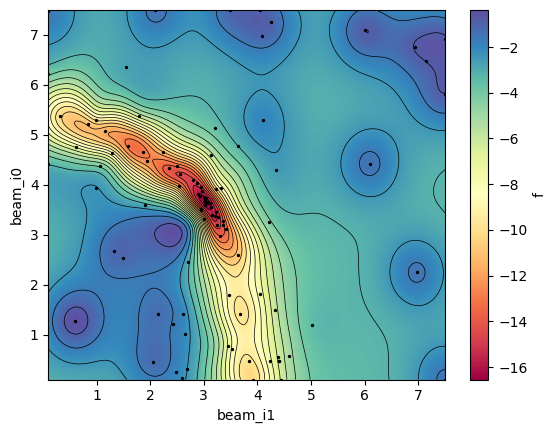

In [3]:
models['f'].plot_model(xname='beam_i1', yname='beam_i0', cmap='Spectral')

Plotting the model in the beam_i1 vs beam_i0 plane


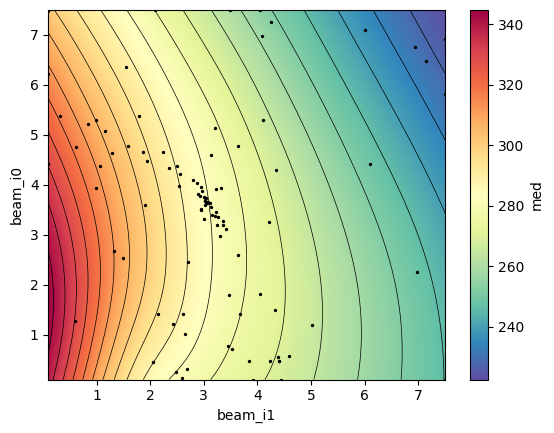

In [4]:
models['med'].plot_model(xname='beam_i1', yname='beam_i0', cmap='Spectral_r')

Plotting the model in the beam_i1 vs beam_i0 plane


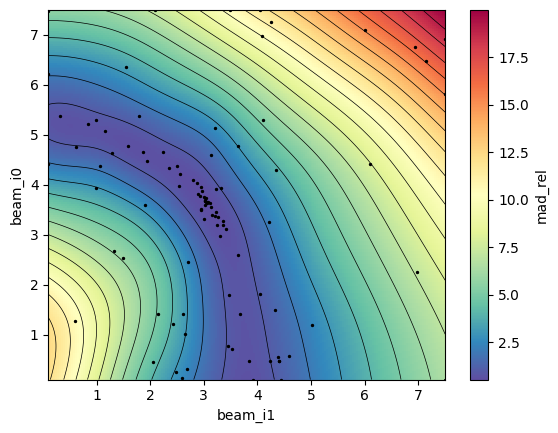

In [5]:
models['mad_rel'].plot_model(xname='beam_i1', yname='beam_i0', cmap='Spectral_r')

#### Get optimal point and information about it

In [6]:
# Get optimum according the model for `f` (this does not necessarily coincides with the minimum from data)
best_arm, best_point_predictions = models['f'].model.model_best_point()
best_pars = best_arm.parameters
print(best_pars)  # best_pars will be used as the reference point

{'beam_i0': 3.670100437277201, 'beam_i1': 3.0246930851729474}


In [7]:
# evaluate model over data sample
df = pp.get_df()
sample = df[pp.varpars] # Use history data as the sample to evaluate
f, _ = models['f'].evaluate_model(sample)
df['fm'] = f  # add model evaluation to data as column
idx_best_data = df['f'].idxmin()  # get index of the data point with minimum f
idx_best_model = df['fm'].idxmin()  # get index of the data point with minimum fm
varlist = ['f', 'fm', 'beam_i0', 'beam_i1', 'med', 'mad_rel', 'q'] # list of variables to print
print('data index where f is minimum: ', idx_best_data)
for var in varlist:
    print('%10s = %10f' % (var, df.loc[idx_best_data][var]))

data index where f is minimum:  54
         f = -16.667123
        fm = -16.514675
   beam_i0 =   3.693381
   beam_i1 =   3.021622
       med = 282.680687
   mad_rel =   0.516917
         q =  74.227208


#### Define the sample of points where to evaluate the models

In [8]:
# Construct a sample of random points around the optimum:
# a Gaussian jitter of 5% rms (w.r.t optimal values)
varpars = pp.varpars
# varpars = ['beam_i1']
# rands = np.random.normal(size=[10000])
rands = np.random.normal(size=[10000, len(varpars)])
sample = np.zeros([10000, len(varpars)])
for i, var in enumerate(varpars): 
    # sample[:, i] = best_pars[var] * (1. + 0.05 * rands)
    sample[:, i] = best_pars[var] * (1. + 0.05 * rands[:, i])
# convert the sample to dataframe
sample = pd.DataFrame(sample, columns=varpars)

#### Evaluate the models over the sample and get statistics (jitters)

In [9]:
# evaluate the models over the sample and create dataframe with the info
fsample = pd.DataFrame(columns=models.keys())
for k in models.keys():
    f, _ = models[k].evaluate_model(sample, p0=best_pars)
    fsample[k] = f 
    f_best = df.loc[idx_best_model][k]
    print('average %s = %.1f +- %.1f%%' % (k, np.average(f), 100 * np.std(f) / np.average(f)))

average f = -13.9 +- -17.7%
average med = 282.8 +- 0.6%
average mad_rel = 0.6 +- 19.8%
average q = 74.0 +- 3.7%


#### Draw correlations

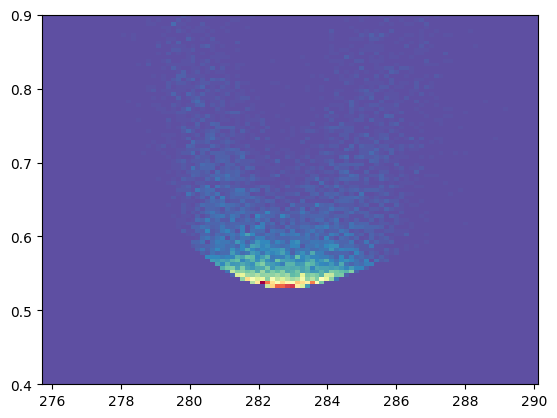

In [10]:
plt.hist2d(fsample['med'], fsample['mad_rel'], 
        range=[[fsample['med'].min(), fsample['med'].max()], [0.4, 0.9]], 
        bins=(100, 100), cmap='Spectral_r');

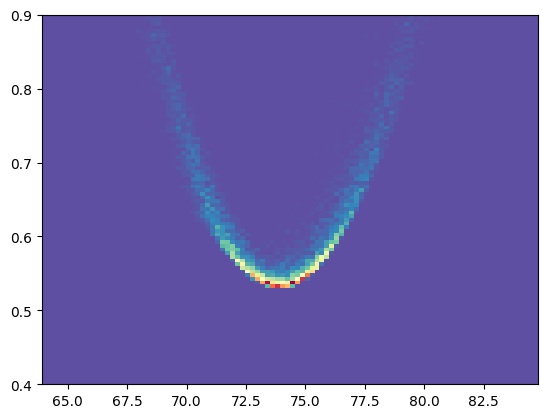

In [11]:
plt.hist2d(fsample['q'], fsample['mad_rel'], 
        range=[[fsample['q'].min(), fsample['q'].max()], [0.4, 0.9]], 
        bins=(100, 100), cmap='Spectral_r');

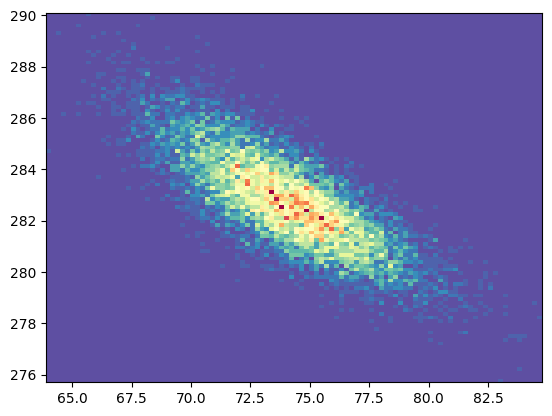

In [12]:
plt.hist2d(fsample['q'], fsample['med'], 
        range=[[fsample['q'].min(), fsample['q'].max()], [fsample['med'].min(), fsample['med'].max()]], 
        bins=(100, 100), cmap='Spectral_r');

#### Use model values to draw a sequence of jittering shots 

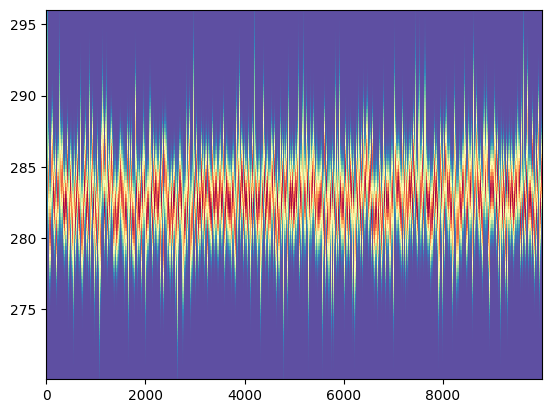

In [13]:
# fsample = fsample.sort_values(by='q', ascending=False)
fq = fsample['q'].to_numpy()
fmed = fsample['med'].to_numpy()
fmad = fmed * fsample['mad_rel'].to_numpy() / 100

def shots2d(x, y):
    i = x.astype(int)
    w = fq[i] * np.exp(-(y - fmed[i])**2 / (2 * fmad[i]**2)) / (np.sqrt(2 * np.pi) * fmad[i])
    return w

xaxis = np.linspace(0, len(sample)-1, len(sample))
yaxis = np.linspace(0.98 * min(fmed), 1.02 * max(fmed), 100)
X, Y = np.meshgrid(xaxis, yaxis)
func = shots2d(X, Y)
im = plt.pcolormesh(xaxis, yaxis, func, 
        cmap='Spectral_r', shading='auto')

#### Project all the shots on the energy axis to evaluate global energy spread

 global energy = 282.67 +- 0.91%


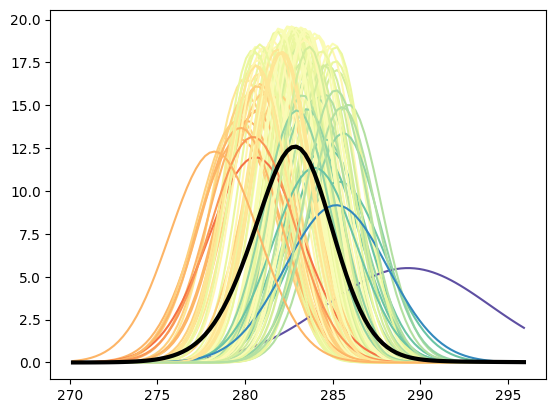

In [14]:
xaxis = np.linspace(0.98 * min(fmed), 1.02 * max(fmed), 100)
ysum = np.zeros_like(xaxis)
ncolors = 20
colors = plt.cm.Spectral_r(np.linspace(0, 1, ncolors))
for i in range(func.shape[0]):
    idxs = np.asarray((i))
    y = shots2d(idxs, xaxis)
    ysum = ysum + y
    icolor = int((ncolors - 1) * (fq[i] - np.amin(fq)) / (np.amax(fq) - np.amin(fq)))
    plt.plot(xaxis, y, color=colors[icolor])

yavg = ysum / func.shape[0]
plt.plot(xaxis, yavg, color='black', lw=3, ls='-')

emean = np.average(xaxis, weights=yavg)
erms = np.sqrt(np.cov(xaxis, aweights=yavg))
print(' global energy = %.2f +- %.2f%%' % (emean, 100 * erms / emean))